In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import random
import math
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, LogVectorOutput

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory

# sponana/src/sponana/utils.py
import sponana.utils
from sponana.controller import SpotController
from sponana.debug_logger import DebugLogger
from sponana.perception import (
    add_camera_pose_extractor,
    add_body_pose_extractor,
    BananaSpotter,
)
import sponana.sim

In [15]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


In [16]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
# simulation_time = -1  # run indefinitely until ESC is pressed
simulation_time = -1
debug = True
add_fixed_cameras = False
enable_arm_ik = True  # turn this off if you find the arm too annoying
use_teleop = False

simulator, diagram = sponana.sim.clutter_gen(
    meshcat,
    rng,
    debug=debug,
    simulation_time=simulation_time,
    add_spot=add_spot,
    add_fixed_cameras=add_fixed_cameras,
    enable_arm_ik=enable_arm_ik,
    use_teleop=use_teleop,
)

x_sample [-0.1   0.05]
y_sample [-2.00000000e-01  2.77555756e-17]
appended: x_points_append: [0.04999999999999999] y_points_append: [2.7755575615628914e-17]
dist 0.15
appended: x_points_append: [0.04999999999999999, -0.1] y_points_append: [2.7755575615628914e-17, 2.7755575615628914e-17]
dist 0.0
dist 0.2
dist 0.25
appended: x_points_append: [0.04999999999999999, -0.1, 0.04999999999999999] y_points_append: [2.7755575615628914e-17, 2.7755575615628914e-17, -0.19999999999999998]
x_sample [-0.1   0.05]
y_sample [-2.00000000e-01  2.77555756e-17]
appended: x_points_append: [-0.1] y_points_append: [-0.19999999999999998]
x_sample [-0.1   0.05]
y_sample [-2.00000000e-01  2.77555756e-17]
appended: x_points_append: [0.04999999999999999] y_points_append: [2.7755575615628914e-17]
dist 0.2
appended: x_points_append: [0.04999999999999999, 0.04999999999999999] y_points_append: [2.7755575615628914e-17, -0.19999999999999998]
dist 0.15
dist 0.25
appended: x_points_append: [0.04999999999999999, 0.049999999

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



Press Escape to stop the simulation


KeyboardInterrupt: 

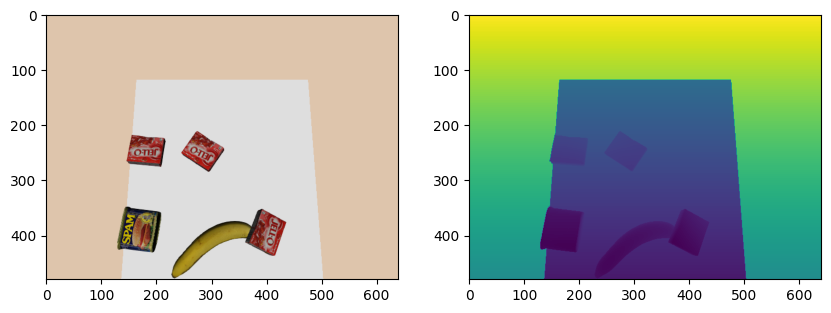

In [ ]:
# Check the camera on table top
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d6be65c-ca3c-46d4-a8f3-21f3622a2ace' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

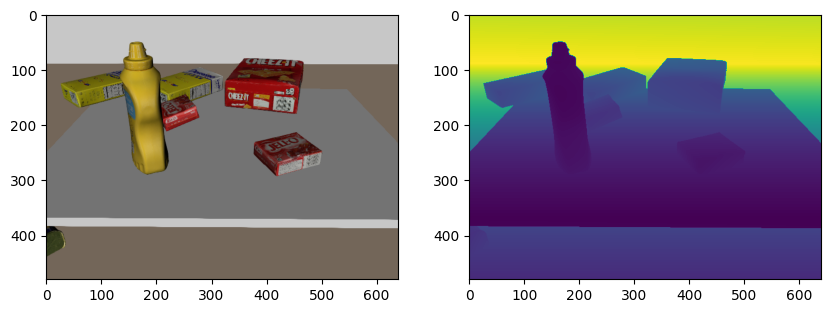

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

intrinsics [[579.41125497   0.         319.5       ]
 [  0.         579.41125497 239.5       ]
 [  0.           0.           1.        ]]
focal length 579.4112549695428 579.4112549695428
field of view 1.0091912899732969 0.7853981633974483


In [ ]:
# Another way to get camera pose (X_PC)
context = simulator.get_mutable_context()
context = camera1.GetMyContextFromRoot(context)
camera1.GetOutputPort("body_pose_in_world").Eval(context)

RigidTransform(
  R=RotationMatrix([
    [-0.008421506105207633, 0.4999822692443502, -0.8659946932147968],
    [0.9999645384887006, 0.004210753052603815, -0.007293238225235556],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[0.556714450088338, -0.0037332741936705253, 0.495],
)

In [ ]:
# Read out the table position from the hardware station

plant = station.GetSubsystemByName("plant")
context = simulator.get_mutable_context()
pcontext = plant.GetMyContextFromRoot(context)
idx = plant.GetBodyByName(
    "table_top_link", plant.GetModelInstanceByName("table_top1")
).index()  # Get this
# get output port with body_poses
# then index into it by index -- see get_body_poses_output_port() docs!!
plant.get_body_poses_output_port().Eval(pcontext)[idx]

RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 0.0, 0.19925],
)

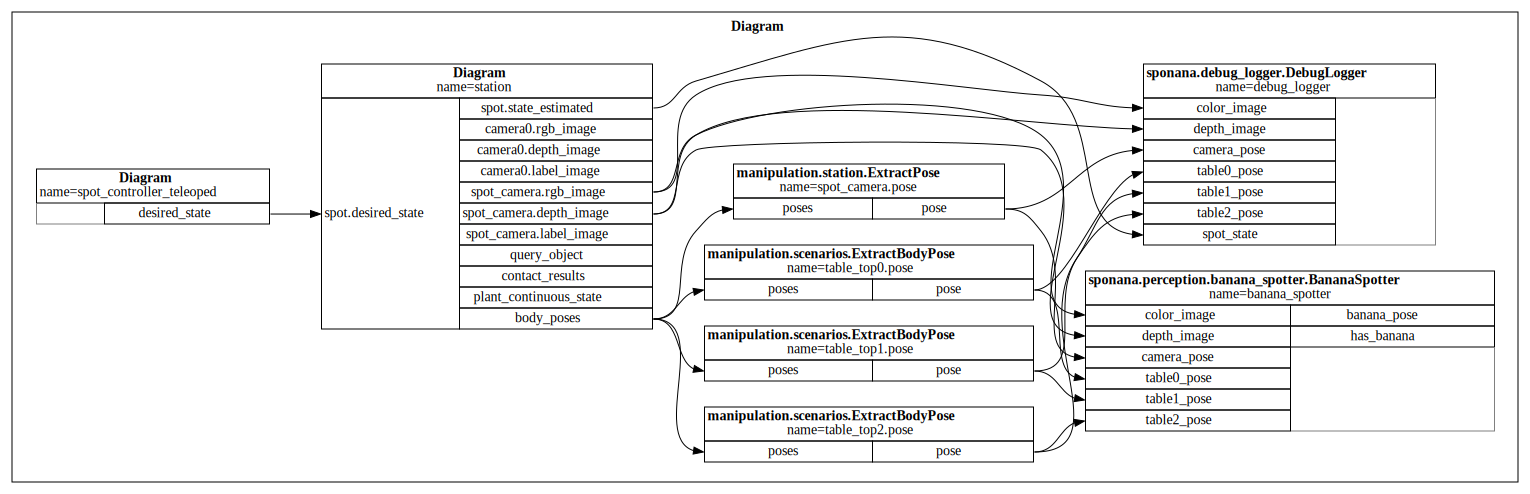

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)